In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, Concatenate, Input
from tensorflow.keras.layers import Conv1D, Flatten, MaxPool1D
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os, re, sys
from sklearn.manifold import TSNE
from tensorflow.keras.utils import plot_model
# fix random seed for reproducibility
np.random.seed(109)

In [2]:
data = pd.read_csv("fake reviews dataset.csv")
corpus = data.text_.to_list()

label_2_id = {"CG": 0, "OR": 1}
labels = np.array([label_2_id[label] for label in data.label])

ratings = data.rating.to_numpy()

In [3]:
# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
max_len = max([len(seq) for seq in sequences])
max_vocab = len(tokenizer.index_word) + 1
padded_sequences = pad_sequences(sequences, maxlen=max_len)

In [4]:
# Split test and training data
train_sentences, test_sentences, train_ratings, test_ratings, train_labels, test_labels = \
train_test_split(padded_sequences, ratings, labels, test_size=0.3, random_state=109)

In [11]:
text_input = Input(shape=(max_len,), name="TextInput")
rating_input = Input(shape=(1,), name="RatingInput")

embedding_layer = Embedding(max_vocab, 36, mask_zero=True)(text_input)
conv_layer = Conv1D(filters=36, kernel_size=3, padding='same', activation='relu')(embedding_layer)
maxpooling_layer = MaxPool1D(pool_size=2)(conv_layer)
flatten_layer = Flatten()(maxpooling_layer)

concatenate_layer = Concatenate()([flatten_layer, rating_input])

output_layer = Dense(1, activation='sigmoid')(concatenate_layer)

model = Model(inputs=[text_input, rating_input], outputs=output_layer)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 TextInput (InputLayer)      [(None, 521)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 521, 36)              1569492   ['TextInput[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 521, 36)              3924      ['embedding_1[0][0]']         
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 260, 36)              0         ['conv1d_1[0][0]']            
 g1D)                                                                                       

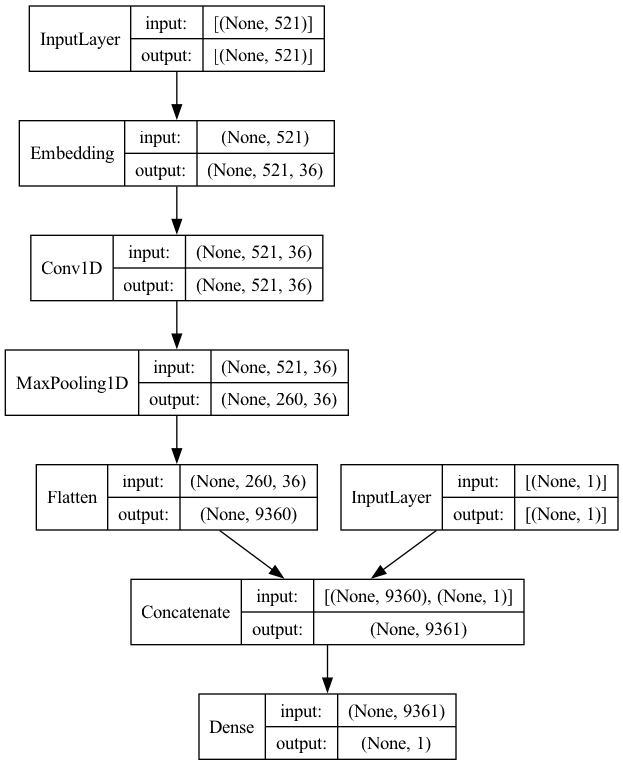

In [12]:
# Plotting the model
plot_model(model, show_shapes=True, show_layer_names=False)

In [7]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=[train_sentences, train_ratings], 
          y=train_labels, 
          validation_data=([test_sentences, test_ratings], test_labels), 
          epochs=2, 
          batch_size=128)

model.save_weights("baseline_model_Conv1D")

Epoch 1/2
222/222 [==============================] - 4s 18ms/step - loss: 0.3842 - accuracy: 0.8078 - val_loss: 0.2012 - val_accuracy: 0.9200
Epoch 2/2
222/222 [==============================] - 4s 18ms/step - loss: 0.1586 - accuracy: 0.9366 - val_loss: 0.1874 - val_accuracy: 0.9273


In [8]:
# Visualize review embeddings
review_embeddings = Model(inputs=[text_input, rating_input], outputs=model.get_layer("concatenate").output)([padded_sequences, ratings], training=False)

tsne = TSNE(n_components=2, random_state=109)
sentence_embeddings_dimension_reduction = tsne.fit_transform(review_embeddings)

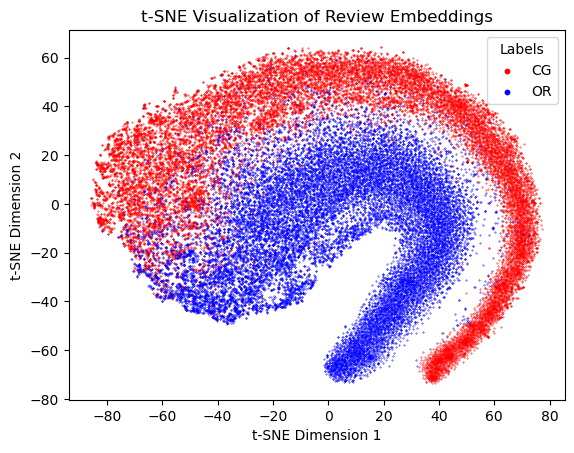

In [9]:
# Plot the t-SNE embeddings
plt.figure()
id_2_label = {0: "CG", 1: "OR"}
id_2_color = {0: "red", 1: "blue"}
for id in id_2_label.keys():
    plt.scatter(sentence_embeddings_dimension_reduction[labels==id, 0], 
                sentence_embeddings_dimension_reduction[labels==id, 1], 
                s=0.1, label=id_2_label[id], c=id_2_color[id])
plt.title("t-SNE Visualization of Review Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
legend = plt.legend(title='Labels')

# Adjust size of dots in legend
for handle in legend.legend_handles:
    handle.set_sizes([10])

plt.show()